In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
np.set_printoptions(precision=4, suppress=True)

save_file = open('daily_HFC_multi_outcome_data_matrix_all.npy','rb')
indicator = np.load(save_file)
raw_preds = np.load(save_file)
raw_conf = np.load(save_file)
raw_wager = np.load(save_file)
raw_se = np.load(save_file)
raw_truth = np.load(save_file)
raw_openday = np.load(save_file)
raw_user_type = np.load(save_file)
raw_user_id = np.load(save_file)
save_file.close()

ifps_data = pd.read_csv("ifps0726_resolved.csv")
raw_ifps_type = ifps_data['type'].values


save_file = open('daily_HFC_data_matrix_agg.npy','rb')
agg_preds = np.load(save_file)
agg_se = np.load(save_file)
#agg_openday = np.load(save_file)
## Truth a vector of {1,2} where 1 means the event happen with probability 1
#truth = np.load(save_file)
save_file.close()

save_file = open('sur_score_matrix0726.npy','rb')
raw_sur_score_matrix = np.load(save_file)
save_file.close()

save_file = open('sur_ind_error_rate_vector0726.npy','rb')
raw_err_ind = np.load(save_file)
save_file.close()

#preds = np.loadtxt(fname="/Users/heliaguin/Academy/EconCS/GJP_data/preds_matrix.csv", delimiter=',', dtype=float)
#truth = np.loadtxt(fname="/Users/heliaguin/Academy/EconCS/GJP_data/truth_vector.csv", delimiter=',', dtype=int)
#wager = np.ones_like(preds)
#conf = np.ones_like(preds)
#mse = np.ones_like(preds)

In [2]:
def entropy_matrix(pred_matrix, axis=-1):
    type_matrix = np.zeros_like(pred_matrix)
    type_matrix[pred_matrix<0] = -1
    type_matrix[(pred_matrix>0) & (pred_matrix<1)] = 1
    entropy_matrix = np.array(pred_matrix)
    entropy_matrix[type_matrix<1] = 0.5
    entropy_matrix = -entropy_matrix * np.log(entropy_matrix)
    entropy_matrix[type_matrix==0] = 0
    entropy_matrix[type_matrix==-1] = np.NAN
    return np.sum(entropy_matrix, axis=axis)

In [6]:
preds = raw_preds[-1]
conf = raw_conf[-1]
wager = raw_wager[-1]
se = raw_se[-1]
sur_score_matrix = raw_sur_score_matrix
err_ind = raw_err_ind
user_type = raw_user_type
user_id = raw_user_id
ifps_type = raw_ifps_type
truth = raw_truth

#valid = user_type==1 #volunteer
#valid = user_type==2 #turker
#valid = user_type==3 #control
valid = user_type<3 # conf-group
#valid = user_type>0 # all
preds = preds[:, valid]
conf = conf[:, valid]
wager = wager[:, valid]
se = se[:, valid]
sur_score_matrix = sur_score_matrix[:, valid]
err_ind = err_ind[valid]
user_type = user_type[valid]
user_id = user_id[valid]

#valid = ifps_type==2 # Binary
valid = ifps_type>0 # ALL
preds = preds[valid]
conf = conf[valid]
wager = wager[valid]
se = se[valid]
sur_score_matrix = sur_score_matrix[valid]
ifps_type = ifps_type[valid]
truth = truth[valid]

valid_wager = wager > 0.1
valid_wager[:, np.max(wager, axis=0)<0.1] = False

type_matrix = np.zeros_like(conf)
for i in range(type_matrix.shape[0]):
    type_matrix[i, :] = ifps_type[i]
    
print(preds.shape)
#entr = (np.log(ifps_type)[:, None] - entropy_matrix(preds)) / np.log(ifps_type)[:, None]
entr = entropy_matrix(preds) / np.log(ifps_type)[:, None]
#entr = entropy_matrix(preds)
preds = preds[:, :, 0]
print(entr.shape)
print(np.nanmax(preds))

print(ifps_type)
print(truth)
print(preds.shape)
print(conf.shape)
print(wager.shape)
print(se.shape)
print(agg_preds.shape)

rank = np.ones_like(se) * np.NAN
for i in range(len(se)):
    tmp_se = se[i]
    tmp_se[tmp_se<=-0.1] = np.NAN
    index = np.argsort(tmp_se)
    total = np.sum(~np.isnan(tmp_se))
    #print(total)
    #print(index)
    for j in range(total):
        rank[i, index[j]] = (j+1) / total
    #print(rank[i][index])
rank = 1-rank
#print(openday[35:70].T)
#print(agg_openday[35:70].T)
#print(ifps_data[['map_id','type']])

mse = se # rename varible for code legency issue

(86, 1037, 5)
(86, 1037)
1.0
[5 3 5 5 3 5 5 5 2 5 5 2 5 5 3 5 5 2 2 5 5 5 5 5 5 5 5 2 2 5 2 2 4 2 2 2 2
 2 4 3 2 2 2 2 3 5 2 5 2 2 3 4 3 2 2 3 5 2 3 2 2 3 2 2 5 2 5 2 2 2 3 5 2 2
 5 5 3 2 2 2 5 4 2 5 5 2]
[3 1 4 4 2 5 2 2 2 5 3 2 4 1 2 5 1 1 1 5 4 1 1 3 2 2 5 2 2 3 1 2 4 2 2 1 2
 1 1 2 1 2 2 1 1 3 2 4 2 1 2 1 3 1 1 1 4 1 1 2 1 2 1 1 5 2 3 2 2 2 1 3 2 2
 3 2 1 1 1 1 1 1 1 2 4 1]
(86, 1037)
(86, 1037)
(86, 1037)
(86, 1037)
(184, 26, 47)


In [4]:
num_preds = np.sum(preds[:, :]>-0.1, axis=1)
num_wager = np.sum(wager>0.1, axis=1)
print(num_preds.shape, num_wager.shape)
print(np.mean(num_preds), np.median(num_preds), np.min(num_preds[num_preds>0]), np.max(num_preds))
print(np.mean(num_wager), np.median(num_wager), np.min(num_wager[num_wager>0]), np.max(num_wager))

(86,) (86,)
99.3488372093 66.5 3 513
53.7674418605 33.5 2 297


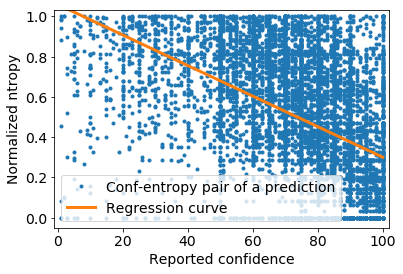

Conf-entr correlation:
(-0.5096846353758695, 0.0)
8318


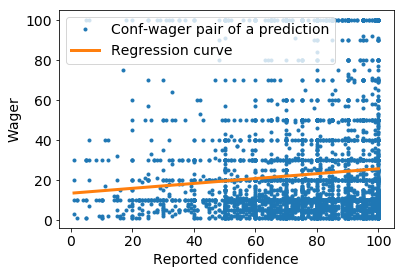

Conf-wager correlation:
(0.098062312288078421, 3.9823489158933399e-11)


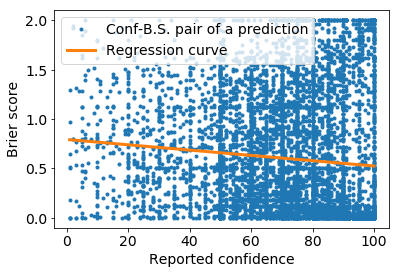

Conf-BS correlation:
(-0.090086608851617608, 1.8460332310224045e-16)


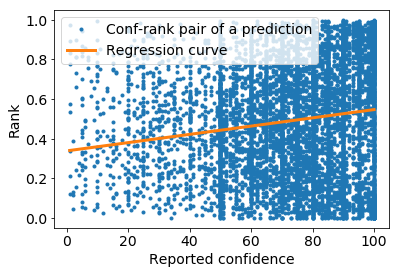

Conf-rank correlation:
(0.15300380870080549, 9.5157038869184998e-45)
[   0.    2.    4.    6.    8.   10.   12.   14.   16.   18.   20.   22.
   24.   26.   28.   30.   32.   34.   36.   38.   40.   42.   44.   46.
   48.   50.   52.   54.   56.   58.   60.   62.   64.   66.   68.   70.
   72.   74.   76.   78.   80.   82.   84.   86.   88.   90.   92.   94.
   96.   98.  100.]


/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in long_scalars


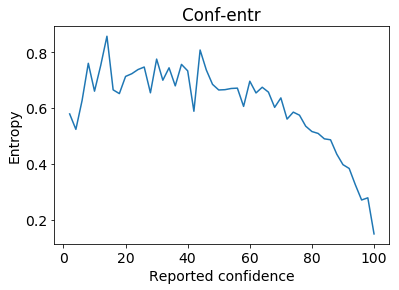

Conf-entr correlation:
(-0.73250748828233991, 1.4815378261413578e-09)


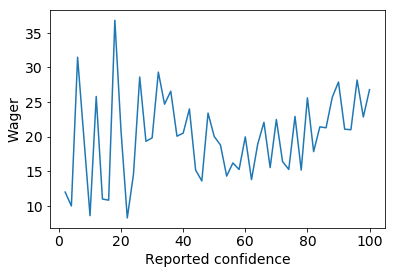

Conf-wager correlation:
(0.20982285997348982, 0.14360938106554827)


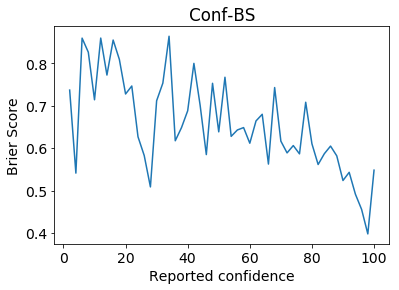

Conf-BS correlation:
(-0.67433943460667178, 7.9233974501501902e-08)


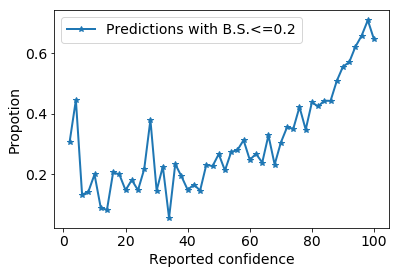

Conf-BS_portion correlation:
(0.77867262024209705, 2.7885365028221305e-11)


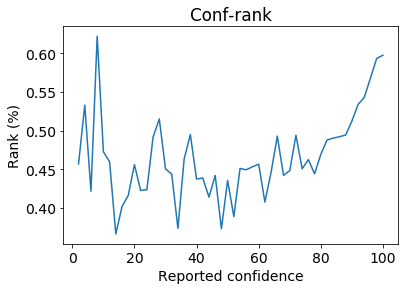

Conf-rank correlation:
(-0.67433943460667178, 7.9233974501501902e-08)


In [141]:
# Relationship of conf and other matrice 
# Based on the whole population!!!!!!
# Note that all the predictions with confidence 50 have a wager 0
import matplotlib
matplotlib.rcParams.update({'font.size': 14})


    
mse = se # rename varible for code legency issue
vec_conf = conf.flatten()
vec_rank = rank.flatten()
vec_type = type_matrix.flatten()
vec_preds = preds.flatten()
vec_entr = entr.flatten()
vec_wager = wager.flatten()
vec_mse = mse.flatten()
vec_valid_wager = valid_wager.flatten()
valid = vec_conf > 0
vec_conf = vec_conf[valid]
vec_rank = vec_rank[valid]
vec_type = vec_type[valid]
vec_preds = vec_preds[valid]
vec_entr = vec_entr[valid]
vec_wager = vec_wager[valid]
vec_mse = vec_mse[valid]
vec_valid_wager = vec_valid_wager[valid]

#r, p = st.pearsonr(vec_conf, np.abs(vec_preds-0.5))
#print(st.t.cdf(r*np.sqrt(len(vec_conf)-2)/np.sqrt(1-r**2), len(vec_conf)-2, loc=0, scale=1))
print('\n\n')
plt.figure(1)
#for i in [2,3,4,5]:
#    plt.plot(vec_conf[vec_type==i], vec_entr[vec_type==i],'.')
plt.plot(vec_conf, vec_entr, '.', label='Conf-entropy pair of a prediction')
x = vec_conf
y = vec_entr
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
plt.xlim([-1, 102])
plt.ylim([-0.05,1.03])
plt.title('')#'Conf-entr')
plt.xlabel('Reported confidence')
plt.ylabel('Normalized ntropy')
plt.legend()
plt.savefig("/Users/heliaguin/Desktop/Conf_Entr_all.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1
           )
plt.show()

print('Conf-entr correlation:')
print(st.pearsonr(vec_conf, vec_entr))
print(len(vec_conf))

plt.figure(2)
x = vec_conf[vec_valid_wager]
y = vec_wager[vec_valid_wager]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_conf[vec_valid_wager], vec_wager[vec_valid_wager],'.', label='Conf-wager pair of a prediction')
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
#plt.title('Conf-wager')
plt.xlabel('Reported confidence')
plt.ylabel('Wager')
plt.legend()
plt.savefig("/Users/heliaguin/Desktop/Conf_wager_all.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1
           )
plt.show()

print('Conf-wager correlation:')
print(st.pearsonr(vec_conf[vec_valid_wager], vec_wager[vec_valid_wager]))

plt.figure(3)
x = vec_conf
y = vec_mse
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_conf, vec_mse,'.', label='Conf-B.S. pair of a prediction')
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
#plt.title('Conf-mse')
plt.xlabel('Reported confidence')
plt.ylabel('Brier score')
plt.legend()
plt.savefig("/Users/heliaguin/Desktop/Conf_BS_all.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1
           )
plt.show()
plt.close('all')

print('Conf-BS correlation:')
print(st.pearsonr(vec_conf, vec_mse))


plt.figure(4)
x = vec_conf
y = vec_rank
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_conf, vec_rank,'.', label='Conf-rank pair of a prediction')
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
#plt.title('Conf-rank')
plt.xlabel('Reported confidence')
plt.ylabel('Rank')
plt.legend()
#plt.savefig("/Users/heliaguin/Desktop/Conf_BS_all.jpg", dpi=150,
#            bbox_inches='tight', pad_inches=0.1
#           )
plt.show()
plt.close('all')
print('Conf-rank correlation:')
print(st.pearsonr(vec_conf, vec_rank))
 

percentiles = 50
perc_mean_preds = np.zeros(percentiles+1)
perc_mean_entr = np.zeros(percentiles+1)
perc_mean_wager = np.zeros(percentiles+1)
perc_mean_mse = np.zeros(percentiles+1)
perc_mean_mse_rate = np.zeros(percentiles+1)
perc_mean_rank = np.zeros(percentiles+1)

for i in range(percentiles+1):
    center = 100 / percentiles * i
    head = center - 100 / percentiles * 0.5
    tail = center + 100 / percentiles * 0.5
    valid = (vec_conf>=head) & (vec_conf<tail)
    #if i+1 < percentiles:
    #    valid = (vec_conf>=head) & (vec_conf<tail)
    #else:
    #    valid = (vec_conf>=head) & (vec_conf<=tail)
    perc_mean_preds[i] = np.mean(np.abs(vec_preds[valid] - 0.5))
    perc_mean_entr[i] = np.mean(vec_entr[valid])
    perc_mean_rank[i] = np.mean(vec_rank[valid])
    perc_mean_wager[i] = np.mean(vec_wager[valid & vec_valid_wager])
    #perc_mean_wager[i] = np.mean(vec_wager[valid])
    perc_mean_mse[i] = np.mean(vec_mse[valid])
    perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
#x_axis = (np.arange(percentiles) + 0.5) / percentiles * 100
x_axis = np.arange(percentiles+1) / percentiles * 100
print(x_axis)

plt.figure(1)
plt.plot(x_axis, perc_mean_entr)
plt.title('Conf-entr')
plt.xlabel('Reported confidence')
plt.ylabel('Entropy')
plt.show()
print('Conf-entr correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_entr)], perc_mean_entr[~np.isnan(perc_mean_entr)]))

plt.figure(2)
plt.plot(x_axis, perc_mean_wager)
#plt.title('Conf-wager')
plt.xlabel('Reported confidence')
plt.ylabel('Wager')
plt.savefig("/Users/heliaguin/Desktop/Conf_wager.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1
           )
plt.show()
print('Conf-wager correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_wager)], perc_mean_wager[~np.isnan(perc_mean_wager)]))

plt.figure(3)
plt.plot(x_axis, perc_mean_mse)
plt.title('Conf-BS')
plt.xlabel('Reported confidence')
plt.ylabel('Brier Score')
plt.show()
plt.close('all')
print('Conf-BS correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse)], perc_mean_mse[~np.isnan(perc_mean_mse)]))

plt.figure(4)
plt.plot(x_axis, perc_mean_mse_rate, '-*', linewidth=2, markersize=6, 
         label='Predictions with B.S.<=0.2')
#plt.title('Conf-BS<=0.2_rate')
plt.xlabel('Reported confidence')
plt.ylabel('Propotion')
plt.legend()
#plt.savefig("/Users/heliaguin/Desktop/Conf_BS_propotion.jpg", dpi=150,
#            bbox_inches='tight', pad_inches=0.1
#           )
plt.show()
plt.close('all')
print('Conf-BS_portion correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse_rate)], perc_mean_mse_rate[~np.isnan(perc_mean_mse_rate)]))

plt.figure(5)
plt.plot(x_axis, perc_mean_rank)
plt.title('Conf-rank')
plt.xlabel('Reported confidence')
plt.ylabel('Rank (%)')
plt.show()
plt.close('all')
print('Conf-rank correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_rank)], perc_mean_mse[~np.isnan(perc_mean_rank)]))

In [117]:
tmp_conf = np.array(conf)
tmp_conf[tmp_conf == -1] = 101
min_conf = np.min(tmp_conf, axis=0)
half_conf = min_conf > 49
#print(min_conf)
print(len(half_conf)-sum(half_conf), sum(half_conf))

319 365


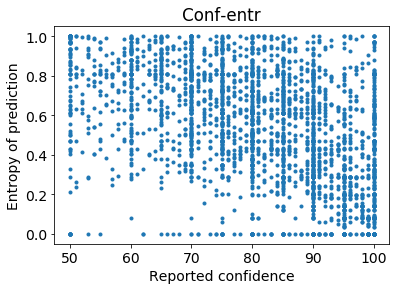

Conf-entr correlation:
(-0.55492145220560962, 2.9955761468281527e-244)


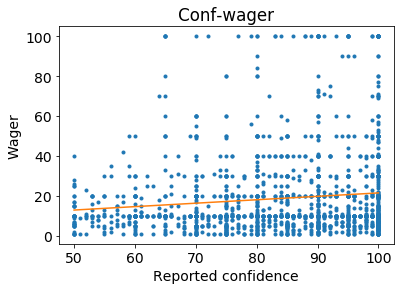

Conf-wager correlation:
(0.11749637983091782, 1.057575182889943e-06)


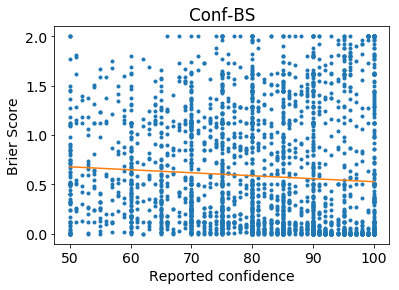

-0.00301274383085 0.829745063296
Conf-BS correlation:
(-0.067572816191687687, 0.0001979013924875181)


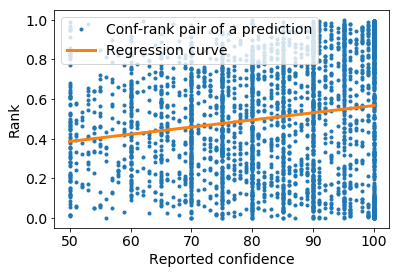

Conf-rank correlation:
(0.17457491624699545, 3.7246348875332374e-22)
[   0.    2.    4.    6.    8.   10.   12.   14.   16.   18.   20.   22.
   24.   26.   28.   30.   32.   34.   36.   38.   40.   42.   44.   46.
   48.   50.   52.   54.   56.   58.   60.   62.   64.   66.   68.   70.
   72.   74.   76.   78.   80.   82.   84.   86.   88.   90.   92.   94.
   96.   98.  100.]





/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in long_scalars


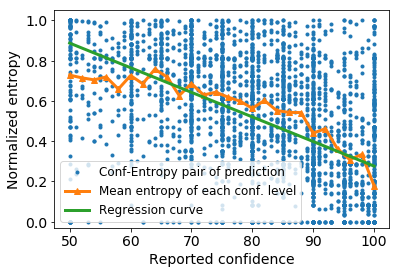

Conf-entr correlation:
(-0.90071422568844028, 3.6187802754105685e-10)
[     nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan  11.3      9.25    12.1111  13.      12.75    13.3571  12.75
  14.3125  26.4889  12.375   17.5938  14.1818  13.625   15.2155  14.2895
  20.8571  16.8409  22.78    16.0625  21.0606  21.6771  19.3556  18.8444
  19.7619  15.3091  22.1714]


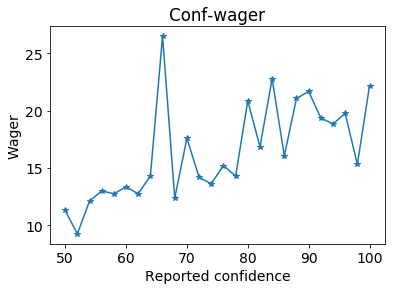

Conf-wager correlation:
(0.65093340079241024, 0.00031692933232335024)


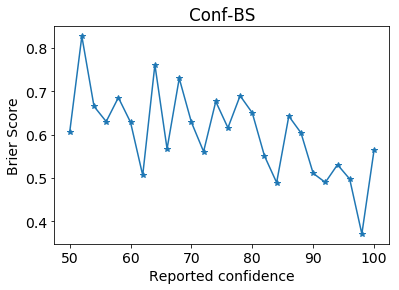

Conf-BS correlation:
(-0.62666109254385705, 0.00061390230038193888)


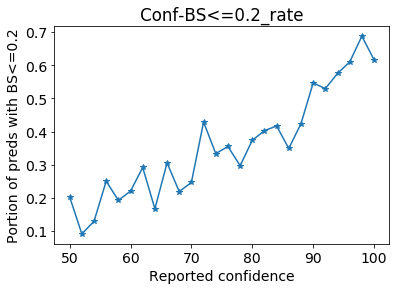

Conf-BS_portion correlation:
(0.92699077094372684, 1.0390317224912098e-11)


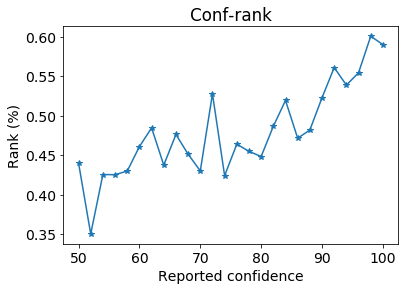

Conf-rank correlation:
(-0.62666109254385705, 0.00061390230038193888)


In [134]:
# Relationship of conf and other matrice 
# Based on the population with confidence range [50, 100]
import matplotlib.pyplot as plt
conf_half_conf = conf[:, half_conf]
preds_half_conf = preds[:, half_conf]
entr_half_conf = entr[:, half_conf]
wager_half_conf = wager[:, half_conf]
mse_half_conf = mse[:, half_conf]
valid_wager_half_conf = valid_wager[:, half_conf]
rank_half_conf = rank[:, half_conf]

vec_conf = conf_half_conf.flatten()
vec_preds = preds_half_conf.flatten()
vec_entr = entr_half_conf.flatten()
vec_wager = wager_half_conf.flatten()
vec_mse = mse_half_conf.flatten()
vec_rank = rank_half_conf.flatten()
vec_valid_wager = valid_wager_half_conf.flatten()
valid = vec_conf > 0
vec_conf = vec_conf[valid]
vec_preds = vec_preds[valid]
vec_entr = vec_entr[valid]
vec_wager = vec_wager[valid]
vec_mse = vec_mse[valid]
vec_rank = vec_rank[valid]
vec_valid_wager = vec_valid_wager[valid]

plt.figure(1)
plt.plot(vec_conf, vec_entr,'.')
plt.title('Conf-entr')
plt.xlabel('Reported confidence')
plt.ylabel('Entropy of prediction')
plt.show()

print('Conf-entr correlation:')
print(st.pearsonr(vec_conf, vec_entr))

plt.figure(2)
x = vec_conf[vec_valid_wager]
y = vec_wager[vec_valid_wager]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_conf[vec_valid_wager], vec_wager[vec_valid_wager],'.')
plt.plot(x, x * a1 + a2)
plt.title('Conf-wager')
plt.xlabel('Reported confidence')
plt.ylabel('Wager')
plt.show()

print('Conf-wager correlation:')
print(st.pearsonr(vec_conf[vec_valid_wager], vec_wager[vec_valid_wager]))

plt.figure(3)
x = vec_conf
y = vec_mse
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_conf, vec_mse,'.')
plt.plot(x, x * a1 + a2)
plt.title('Conf-BS')
plt.xlabel('Reported confidence')
plt.ylabel('Brier Score')
plt.show()
plt.close('all')
print(a1, a2)
print('Conf-BS correlation:')
print(st.pearsonr(vec_conf, vec_mse))

plt.figure(4)
x = vec_conf
y = vec_rank
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_conf, vec_rank,'.', label='Conf-rank pair of a prediction')
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
#plt.title('Conf-rank')
plt.xlabel('Reported confidence')
plt.ylabel('Rank')
plt.legend()
#plt.savefig("/Users/heliaguin/Desktop/Conf_BS_all.jpg", dpi=150,
#            bbox_inches='tight', pad_inches=0.1
#           )
plt.show()
plt.close('all')
print('Conf-rank correlation:')
print(st.pearsonr(vec_conf, vec_rank))

percentiles = 50
perc_mean_preds = np.zeros(percentiles+1)
perc_mean_entr = np.zeros(percentiles+1)
perc_mean_wager = np.zeros(percentiles+1)
perc_mean_mse = np.zeros(percentiles+1)
perc_mean_mse_rate = np.zeros(percentiles+1)
perc_mean_rank = np.zeros(percentiles+1)
#perc_a
for i in range(percentiles+1):
    center = 100 / percentiles * i
    head = center - 100 / percentiles * 0.5
    tail = center + 100 / percentiles * 0.5
    valid = (vec_conf>=head) & (vec_conf<tail)
    #if i+1 < percentiles:
    #    valid = (vec_conf>=head) & (vec_conf<tail)
    #else:
    #    valid = (vec_conf>=head) & (vec_conf<=tail)
    perc_mean_preds[i] = np.mean(np.abs(vec_preds[valid] - 0.5))
    perc_mean_entr[i] = np.mean(vec_entr[valid])
    perc_mean_rank[i] = np.mean(vec_rank[valid])
    perc_mean_wager[i] = np.mean(vec_wager[valid & vec_valid_wager])
    #perc_mean_wager[i] = np.mean(vec_wager[valid])
    perc_mean_mse[i] = np.mean(vec_mse[valid])
    perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
#x_axis = (np.arange(percentiles) + 0.5) / percentiles * 100
x_axis = np.arange(percentiles+1) / percentiles * 100
print(x_axis)
cross_cell_perc_mean_entr = np.array(perc_mean_entr[:])
cross_cell_perc_mean_wager = np.array(perc_mean_wager[:])
cross_cell_perc_mean_mse_rate = np.array(perc_mean_mse_rate[:])

print('\n\n')
plt.figure(1)
plt.plot(vec_conf, vec_entr,'.', label="Conf-Entropy pair of prediction")
plt.plot(x_axis, perc_mean_entr, '-^', linewidth=3, markersize=6, label="Mean entropy of each conf. level")
x = vec_conf
y = vec_entr
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
plt.ylim([-0.03,1.05])
#plt.title('Conf-entr')
plt.xlabel('Reported confidence')
plt.ylabel('Normalized entropy')
plt.legend(prop={'size': 12})
plt.show()
print('Conf-entr correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_entr)], perc_mean_entr[~np.isnan(perc_mean_entr)]))

print(perc_mean_wager)
plt.figure(2)
plt.plot(x_axis, perc_mean_wager, '-*')
plt.title('Conf-wager')
plt.xlabel('Reported confidence')
plt.ylabel('Wager')
plt.show()
print('Conf-wager correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_wager)], perc_mean_wager[~np.isnan(perc_mean_wager)]))

plt.figure(3)
plt.plot(x_axis, perc_mean_mse, '-*')
plt.title('Conf-BS')
plt.xlabel('Reported confidence')
plt.ylabel('Brier Score')
plt.show()
plt.close('all')
print('Conf-BS correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse)], perc_mean_mse[~np.isnan(perc_mean_mse)]))

plt.figure(4)
plt.plot(x_axis, perc_mean_mse_rate, '-*')
plt.title('Conf-BS<=0.2_rate')
plt.xlabel('Reported confidence')
plt.ylabel('Portion of preds with BS<=0.2')
plt.show()
plt.close('all')
print('Conf-BS_portion correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse_rate)], perc_mean_mse_rate[~np.isnan(perc_mean_mse_rate)]))

plt.figure(5)
plt.plot(x_axis, perc_mean_rank, '-*')
plt.title('Conf-rank')
plt.xlabel('Reported confidence')
plt.ylabel('Rank (%)')
plt.show()
plt.close('all')
print('Conf-rank correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_rank)], perc_mean_mse[~np.isnan(perc_mean_rank)]))

In [135]:
print(cross_cell_perc_mean_mse_rate)

[    nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan  0.2022  0.0909
  0.129   0.25    0.1923  0.2202  0.2917  0.1667  0.3053  0.2188  0.2463
  0.4286  0.3333  0.3548  0.2969  0.3734  0.4026  0.4167  0.3487  0.4237
  0.5466  0.5294  0.5753  0.6098  0.6875  0.6168]


(86, 319)


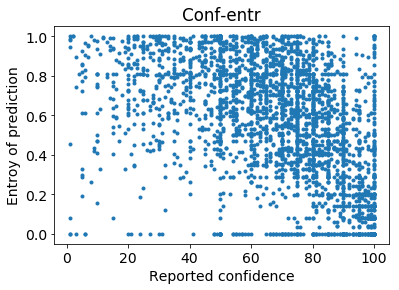

Conf-entr correlation:
(-0.53736738590776389, 1.570088105877232e-235)


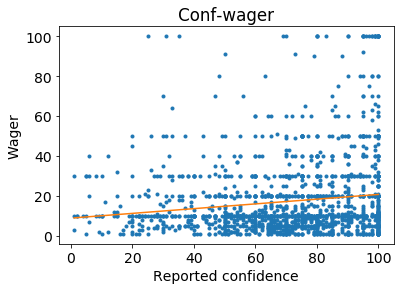

Conf-wager correlation:
(0.14407436112217722, 1.5698546748516685e-09)


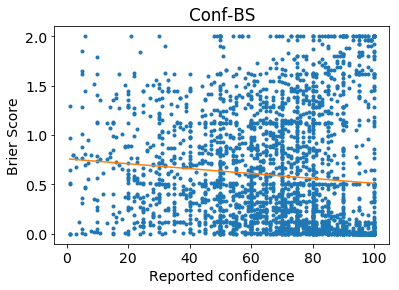

-0.00247647551026 0.75968160838
Conf-BS correlation:
(-0.095827699438315483, 6.967427503620335e-08)


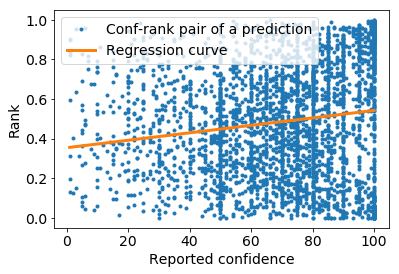

Conf-rank correlation:
(0.15432729537213444, 2.8839872163259033e-18)
[   0.    2.    4.    6.    8.   10.   12.   14.   16.   18.   20.   22.
   24.   26.   28.   30.   32.   34.   36.   38.   40.   42.   44.   46.
   48.   50.   52.   54.   56.   58.   60.   62.   64.   66.   68.   70.
   72.   74.   76.   78.   80.   82.   84.   86.   88.   90.   92.   94.
   96.   98.  100.]





/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in long_scalars


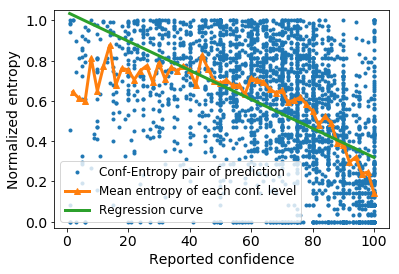

Conf-entr correlation:
(-0.75307238816736877, 2.8098634874725027e-10)


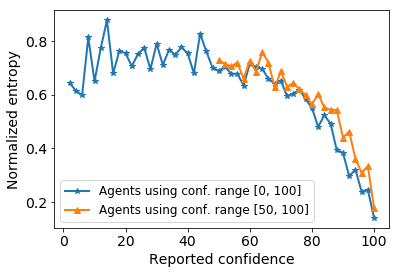

[     nan  12.6     10.      21.      20.      10.4286  19.6667  11.
  13.875    3.      15.3571   8.2727   9.625   25.3636  12.3077  16.7778
  26.3333  20.8333  21.7857  15.0833  13.2069   7.8333  16.3846  11.5294
  18.5926  14.2812   9.9583  12.6207  15.8438  10.5556  14.971   12.4848
  15.2222  11.8182  11.      15.1279  13.7949  13.5581  17.9381  15.725
  17.4128  14.2051  15.      16.3944  22.0303  20.3298  19.      18.5
  27.05    30.1667  22.3013]


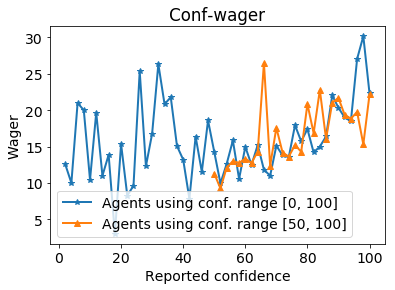

Conf-wager correlation:
(0.3368598904133181, 0.016752857108759671)
(0.78388423150750564, 2.1664253448166267e-06)


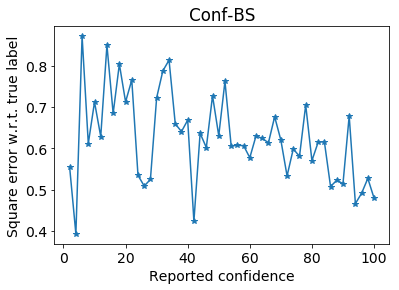

Conf-BS correlation:
(-0.40297874226969393, 0.0037131855155988088)


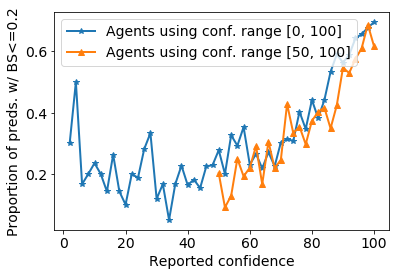

Conf-BS_portion correlation:
(0.72666294660324471, 2.3121386168549918e-09)


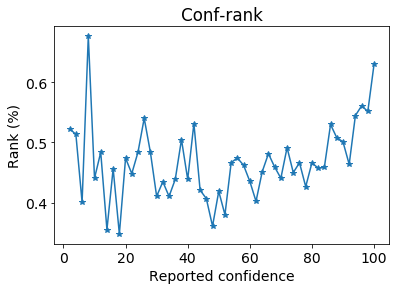

Conf-rank correlation:
(-0.40297874226969393, 0.0037131855155988088)


In [138]:
# Relations of conf and other matrice 
# Based on the population with confidence range [0, 100]
import matplotlib.pyplot as plt
conf_full_conf = conf[:, ~half_conf]
preds_full_conf = preds[:, ~half_conf]
entr_full_conf = entr[:, ~half_conf]
wager_full_conf = wager[:, ~half_conf]
mse_full_conf = mse[:, ~half_conf]
valid_wager_full_conf = valid_wager[:, ~half_conf]
rank_full_conf = rank[:, ~half_conf]

print(mse_full_conf.shape)
#aasds

vec_conf = conf_full_conf.flatten()
vec_preds = preds_full_conf.flatten()
vec_entr = entr_full_conf.flatten()
vec_wager = wager_full_conf.flatten()
vec_mse = mse_full_conf.flatten()
vec_valid_wager = valid_wager_full_conf.flatten()
vec_rank = rank_full_conf.flatten()
valid = vec_conf > 0
vec_conf = vec_conf[valid]
vec_preds = vec_preds[valid]
vec_entr = vec_entr[valid]
vec_wager = vec_wager[valid]
vec_mse = vec_mse[valid]
vec_rank = vec_rank[valid]
vec_valid_wager = vec_valid_wager[valid]


plt.figure(1)
plt.plot(vec_conf, vec_entr,'.')
plt.title('Conf-entr')
plt.xlabel('Reported confidence')
plt.ylabel('Entroy of prediction')
plt.show()

print('Conf-entr correlation:')
print(st.pearsonr(vec_conf, vec_entr))

plt.figure(2)
x = vec_conf[vec_valid_wager]
y = vec_wager[vec_valid_wager]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_conf[vec_valid_wager], vec_wager[vec_valid_wager],'.')
plt.plot(x, x * a1 + a2)
plt.title('Conf-wager')
plt.xlabel('Reported confidence')
plt.ylabel('Wager')
plt.show()

print('Conf-wager correlation:')
print(st.pearsonr(vec_conf[vec_valid_wager], vec_wager[vec_valid_wager]))

plt.figure(3)
x = vec_conf
y = vec_mse
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_conf, vec_mse,'.')
plt.plot(x, x * a1 + a2)
plt.title('Conf-BS')
plt.xlabel('Reported confidence')
plt.ylabel('Brier Score')
plt.show()
plt.close('all')
print(a1, a2)

print('Conf-BS correlation:')
print(st.pearsonr(vec_conf, vec_mse))

plt.figure(4)
x = vec_conf
y = vec_rank
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_conf, vec_rank,'.', label='Conf-rank pair of a prediction')
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
#plt.title('Conf-rank')
plt.xlabel('Reported confidence')
plt.ylabel('Rank')
plt.legend()
#plt.savefig("/Users/heliaguin/Desktop/Conf_BS_all.jpg", dpi=150,
#            bbox_inches='tight', pad_inches=0.1
#           )
plt.show()
plt.close('all')
print('Conf-rank correlation:')
print(st.pearsonr(vec_conf, vec_rank))

percentiles = 50
perc_mean_preds = np.zeros(percentiles+1)
perc_mean_entr = np.zeros(percentiles+1)
perc_mean_wager = np.zeros(percentiles+1)
perc_mean_mse = np.zeros(percentiles+1)
perc_mean_rate = np.zeros(percentiles+1)
perc_mean_rank = np.zeros(percentiles+1)
#perc_a
for i in range(percentiles+1):
    center = 100 / percentiles * i
    head = center - 100 / percentiles * 0.5
    tail = center + 100 / percentiles * 0.5
    valid = (vec_conf>=head) & (vec_conf<tail)
    #if i+1 < percentiles:
    #    valid = (vec_conf>=head) & (vec_conf<tail)
    #else:
    #    valid = (vec_conf>=head) & (vec_conf<=tail)
    perc_mean_preds[i] = np.mean(np.abs(vec_preds[valid] - 0.5))
    perc_mean_wager[i] = np.mean(vec_wager[valid & (vec_valid_wager)])
    perc_mean_entr[i] = np.mean(vec_entr[valid])
    #perc_mean_wager[i] = np.mean(vec_wager[valid])
    perc_mean_mse[i] = np.mean(vec_mse[valid])
    perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
    perc_mean_rank[i] = np.mean(vec_rank[valid])
#x_axis = (np.arange(percentiles) + 0.5) / percentiles * 100
x_axis = np.arange(percentiles+1) / percentiles * 100
print(x_axis)

print('\n\n')
plt.figure(1)
plt.plot(vec_conf, vec_entr,'.', label="Conf-Entropy pair of prediction")
plt.plot(x_axis, perc_mean_entr, '-^', linewidth=3, markersize=6, label="Mean entropy of each conf. level")
x = vec_conf
y = vec_entr
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
plt.ylim([-0.03,1.05])
#plt.title('Conf-entr')
plt.xlabel('Reported confidence')
plt.ylabel('Normalized entropy')
plt.legend(prop={'size': 12})
plt.savefig("/Users/heliaguin/Desktop/Conf_Entr_0_100.jpg", dpi=150,
            #facecolor='w', edgecolor='w',
            #orientation='portrait', papertype=None, format=None,
            #transparent=False, 
            bbox_inches='tight', pad_inches=0.1,
            #frameon=None
           )
plt.show()
print('Conf-entr correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_entr)], perc_mean_entr[~np.isnan(perc_mean_entr)]))

plt.figure(10)
plt.plot(x_axis, perc_mean_entr, '-*', linewidth=2, markersize=6, label="Agents using conf. range [0, 100]")
plt.plot(x_axis, cross_cell_perc_mean_entr, '-^', linewidth=2, markersize=6, 
         label="Agents using conf. range [50, 100]")
#plt.title('Conf-entr')
plt.xlabel('Reported confidence')
plt.ylabel('Normalized entropy')
plt.legend(prop={'size': 12})
plt.savefig("/Users/heliaguin/Desktop/Conf_Entr_two_groups.jpg", dpi=150,
            #facecolor='w', edgecolor='w',
            #orientation='portrait', papertype=None, format=None,
            #transparent=False, 
            bbox_inches='tight', pad_inches=0.1,
            #frameon=None
           )
plt.show()

print(perc_mean_wager)
plt.figure(2)
plt.plot(x_axis, perc_mean_wager,  '-*', linewidth=2, markersize=6, label="Agents using conf. range [0, 100]")
plt.plot(x_axis, cross_cell_perc_mean_wager,  '-^', linewidth=2, markersize=6, 
         label="Agents using conf. range [50, 100]")

plt.title('Conf-wager')
plt.xlabel('Reported confidence')
plt.ylabel('Wager')
plt.legend()
plt.savefig("/Users/heliaguin/Desktop/Conf_wager_two_groups.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1,
           )
plt.show()
print('Conf-wager correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_wager)], perc_mean_wager[~np.isnan(perc_mean_wager)]))
print(st.pearsonr(x_axis[~np.isnan(cross_cell_perc_mean_wager)],
                  perc_mean_wager[~np.isnan(cross_cell_perc_mean_wager)]))

plt.figure(3)
plt.plot(x_axis, perc_mean_mse, '-*')
plt.title('Conf-BS')
plt.xlabel('Reported confidence')
plt.ylabel('Square error w.r.t. true label')
plt.show()
plt.close('all')
print('Conf-BS correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse)], perc_mean_mse[~np.isnan(perc_mean_mse)]))

plt.figure(4)
plt.plot(x_axis, perc_mean_mse_rate,  '-*', linewidth=2, markersize=6, label="Agents using conf. range [0, 100]")
plt.plot(x_axis, cross_cell_perc_mean_mse_rate,  '-^', linewidth=2, markersize=6, 
         label="Agents using conf. range [50, 100]")
#plt.title('Conf-BS<=0.2_rate')
plt.xlabel('Reported confidence')
plt.ylabel('Proportion of preds. w/ BS<=0.2')
plt.legend()
plt.savefig("/Users/heliaguin/Desktop/Conf_BS_propotion.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1
           )
plt.show()
plt.close('all')
print('Conf-BS_portion correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse_rate)], perc_mean_mse_rate[~np.isnan(perc_mean_mse_rate)]))

plt.figure(5)
plt.plot(x_axis, perc_mean_rank, '-*')
plt.title('Conf-rank')
plt.xlabel('Reported confidence')
plt.ylabel('Rank (%)')
plt.show()
plt.close('all')
print('Conf-rank correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_rank)], perc_mean_mse[~np.isnan(perc_mean_rank)]))

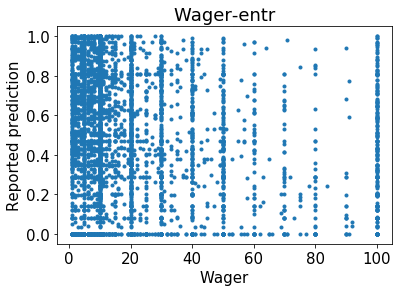

Wager-entr correlation:
(-0.17537120528555525, 2.9549427851132659e-33)


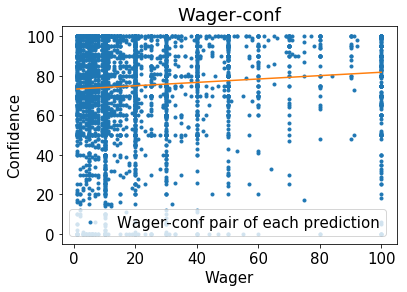

Wager-conf correlation:
(0.093277107321903641, 2.084442424761846e-10)


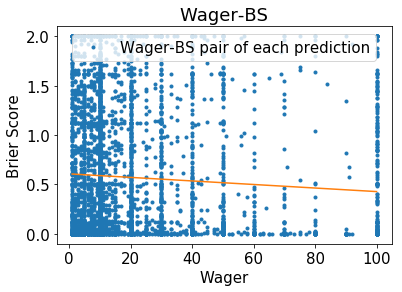

Wager-BS correlation:
(-0.071275127841742447, 1.2248842042526998e-06)
[   0.    2.    4.    6.    8.   10.   12.   14.   16.   18.   20.   22.
   24.   26.   28.   30.   32.   34.   36.   38.   40.   42.   44.   46.
   48.   50.   52.   54.   56.   58.   60.   62.   64.   66.   68.   70.
   72.   74.   76.   78.   80.   82.   84.   86.   88.   90.   92.   94.
   96.   98.  100.]


/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in long_scalars


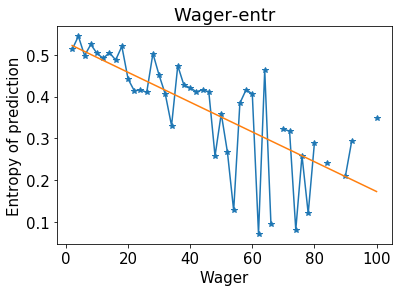

(-0.73237524149470534, 2.3783067821674753e-08)


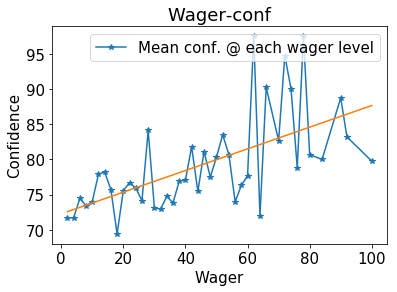

(0.60860063118960339, 1.4916863418784512e-05)


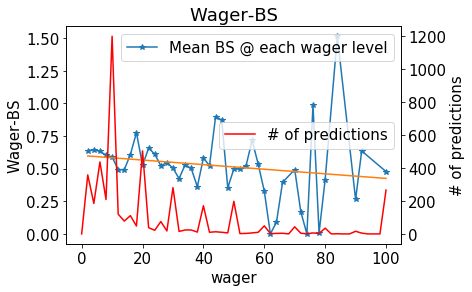

Wager-BS correlation:
(-0.17653470549154979, 0.25745558823976566)


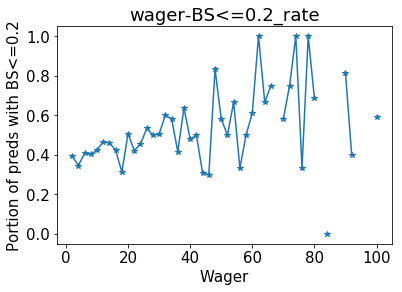

Wager-BS_portion correlation:
(0.37623421918289068, 0.012898842053197468)


In [8]:
# Relations of wager and other matrice 
# Based on the population with confidence range [0, 100]

# Relationship of conf and other matrice 
# Based on the whole population!!!!!!
# Note that all the predictions with confidence 50 have a wager 0

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

vec_conf = conf[0:].flatten()
vec_preds = preds[0:].flatten()
vec_entr = entr[0:].flatten()
vec_wager = wager[0:].flatten()
vec_mse = mse[0:].flatten()
valid = (vec_preds > -0.1) & (vec_wager>0)# & (vec_wager<100)
vec_conf = vec_conf[valid]
vec_preds = vec_preds[valid]
vec_entr = vec_entr[valid]
vec_wager = vec_wager[valid]
vec_mse = vec_mse[valid]

postive_wager = vec_wager > 0

plt.figure(1)
plt.plot(vec_wager, vec_entr,'.')
plt.title('Wager-entr')
plt.xlabel('Wager')
plt.ylabel('Reported prediction')
plt.show()

print('Wager-entr correlation:')
print(st.pearsonr(vec_wager, vec_entr))

plt.figure(2)
x = vec_wager[postive_wager]
y = vec_conf[postive_wager]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_wager[vec_wager>=0], vec_conf[vec_wager>=0],'.', label = 'Wager-conf pair of each prediction')
plt.plot(x, x * a1 + a2)
plt.title('Wager-conf')
plt.xlabel('Wager')
plt.ylabel('Confidence')
plt.legend()
plt.show()
print('Wager-conf correlation:')
print(st.pearsonr(vec_wager, vec_conf))

plt.figure(3)
x = vec_wager[postive_wager]
y = vec_mse[postive_wager]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(vec_wager[postive_wager], vec_mse[postive_wager],'.', label = 'Wager-BS pair of each prediction')
plt.plot(x, x * a1 + a2)
plt.title('Wager-BS')
plt.xlabel('Wager')
plt.ylabel('Brier Score')
plt.legend()
plt.show()
plt.close('all')
print('Wager-BS correlation:')
print(st.pearsonr(vec_wager, vec_mse))


percentiles = 50
perc_mean_preds = np.zeros(percentiles+1)
perc_mean_entr = np.zeros(percentiles+1)
perc_mean_conf = np.zeros(percentiles+1)
perc_mean_mse = np.zeros(percentiles+1)
perc_mean_mse_rate = np.zeros(percentiles+1)
perc_num = np.zeros(percentiles+1)
#perc_a
for i in range(percentiles+1):
    center = 100 / percentiles * i
    head = center - 100 / percentiles * 0.5
    tail = center + 100 / percentiles * 0.5
    valid = (vec_wager>=head) & (vec_wager<tail)
    #if i+1 < percentiles:
    #    valid = (vec_conf>=head) & (vec_conf<tail)
    #else:
    #    valid = (vec_conf>=head) & (vec_conf<=tail)
    perc_num[i] = np.sum(valid)
    perc_mean_preds[i] = np.mean(np.abs(vec_preds[valid] - 0.5))
    perc_mean_entr[i] = np.mean(vec_entr[valid])
    #perc_mean_wager[i] = np.mean(vec_wager[valid & (vec_wager>0)])
    perc_mean_conf[i] = np.mean(vec_conf[valid])
    perc_mean_mse[i] = np.mean(vec_mse[valid])
    perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
#x_axis = (np.arange(percentiles) + 0.5) / percentiles * 100
x_axis = np.arange(percentiles+1) / percentiles * 100
print(x_axis)

plt.figure(1)
plt.plot(x_axis, perc_mean_entr, '-*')
plt.title('Wager-entr')
plt.xlabel('Wager')
plt.ylabel('Entropy of prediction')
x = x_axis[~np.isnan(perc_mean_entr)]
y = perc_mean_entr[~np.isnan(perc_mean_entr)]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2)
plt.show()
print(st.pearsonr(x_axis[~np.isnan(perc_mean_entr)], perc_mean_entr[~np.isnan(perc_mean_entr)]))

plt.figure(2)
x = x_axis[~np.isnan(perc_mean_conf)]
y = perc_mean_conf[~np.isnan(perc_mean_conf)]
plt.plot(x, y, '-*', label="Mean conf. @ each wager level")
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2)
plt.title('Wager-conf')
plt.xlabel('Wager')
plt.ylabel('Confidence')
plt.legend()
plt.show()
print(st.pearsonr(x_axis[~np.isnan(perc_mean_conf)], perc_mean_conf[~np.isnan(perc_mean_conf)]))

plt.figure(3)
x = x_axis[~np.isnan(perc_mean_mse)]
y = perc_mean_mse[~np.isnan(perc_mean_mse)]


fig, ax1 = plt.subplots()
ax1.set_xlabel('wager')
ax1.set_ylabel('Wager-BS')
ax1.plot(x, y, '-*', label="Mean BS @ each wager level")
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
ax1.plot(x, x * a1 + a2)
#ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('# of predictions') #, color=color)  # we already handled the x-label with ax1
ax2.plot(np.linspace(0, 100, percentiles+1), perc_num, 'r', label='# of predictions')
ax1.legend()
ax2.legend(loc="center right")
plt.title('Wager-BS')
#plt.xlabel('Wager')
#plt.ylabel('Brier Score')
plt.show()



print('Wager-BS correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse)], perc_mean_mse[~np.isnan(perc_mean_mse)]))
plt.figure(4)
plt.plot(x_axis, perc_mean_mse_rate, '-*')
plt.title('wager-BS<=0.2_rate')
plt.xlabel('Wager')
plt.ylabel('Portion of preds with BS<=0.2')
plt.show()
plt.close('all')
print('Wager-BS_portion correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse_rate)], perc_mean_mse_rate[~np.isnan(perc_mean_mse_rate)]))

(86, 2094)
353
1303
2182
0.402841429881


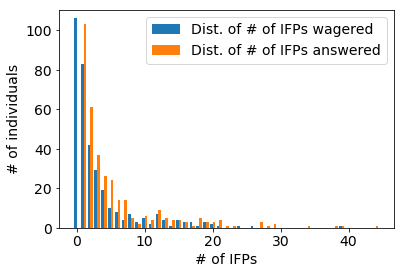

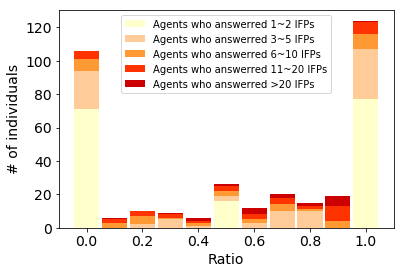

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]
2.96721311475
10.1842105263
19.2857142857
18.3333333333


In [40]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
last_wager = np.max(raw_wager, axis=0)
print(last_wager.shape)

preds = raw_preds[-1][:,user_type==1, 0]
wager = last_wager[:,user_type==1]
num_wager = np.nansum(wager>0.1, axis=0)
num_preds = np.nansum(preds>-0.1, axis=0)
print(np.sum(num_preds - num_wager>=0))
print(np.sum(wager>0.1))
print(np.sum(preds>-0.1))
print((np.sum(preds>-0.1) - np.sum(wager>0.1))/np.sum(preds>-0.1))
bins = [-0.5+i for i in range(46)]
#his_wager, bins = np.histogram(num_wager, bins=bins)

ratio = num_wager / num_preds

plt.figure(1)
plt.hist([num_wager,num_preds], bins, align='mid', rwidth=0.8, 
         label=['Dist. of # of IFPs wagered','Dist. of # of IFPs answered'])
plt.ylabel('# of individuals')
plt.xlabel('# of IFPs')
plt.ylim([0, 110])
plt.legend()
plt.savefig("/Users/heliaguin/Desktop/Wager_dist_turker.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1
           )
plt.show()
plt.close('All')

plt.figure(2)
count, bins, patches = plt.hist(ratio[num_preds<=2], bins=np.linspace(0, 1.1, 12)-0.05, align='mid', rwidth=0.9, 
                                color='#FFFFCC',
                                label='Agents who answerred 1~2 IFPs')
bottom = count
count, bins, patches = plt.hist(ratio[(num_preds>2) & (num_preds<=5)],
                                bins=np.linspace(0, 1.1, 12)-0.05, align='mid', rwidth=0.9,
                                color='#FFCC99',
                                bottom=bottom,
                                label='Agents who answerred 3~5 IFPs')
bottom += count
count, bins, patches = plt.hist(ratio[(num_preds>5) & (num_preds<=10)], 
                                bins=np.linspace(0, 1.1, 12)-0.05, align='mid', rwidth=0.9,
                                color='#FF9933',
                                bottom=bottom,
                                label='Agents who answerred 6~10 IFPs')
bottom += count
count, bins, patches = plt.hist(ratio[(num_preds>10) & (num_preds<=20)], 
                                bins=np.linspace(0, 1.1, 12)-0.05, align='mid', rwidth=0.9,
                                color='#FF3300',
                                bottom=bottom,
                                label='Agents who answerred 11~20 IFPs')
bottom += count
count, bins, patches = plt.hist(ratio[num_preds>20], 
                                bins=np.linspace(0, 1.1, 12)-0.05, align='mid', rwidth=0.9,
                                color='#CC0000',
                                bottom=bottom,
                                label='Agents who answerred >20 IFPs')
#plt.title('Ratio of # of IFPs wagered to # of IFPs answered')
plt.ylabel('# of individuals')
plt.xlabel('Ratio')
plt.legend(prop={'size': 10})
plt.savefig("/Users/heliaguin/Desktop/Wager_ratio_turker.jpg", dpi=150,
            bbox_inches='tight', pad_inches=0.1
           )
plt.show()
plt.close('All')
print(np.linspace(0,1,21))


print(np.mean(num_preds[ratio>0.99]))
print(np.mean(num_preds[(ratio<=0.65) & (ratio>=0.45) ]))
print(np.mean(num_preds[(ratio<=0.45) & (ratio>=0.35) ]))
print(np.mean(num_preds[(ratio<=0.15) & (ratio>=0.05) ]))

In [132]:
entr = (np.log(ifps_type)[:, None] - entropy_matrix(raw_preds[-1])) / np.log(ifps_type)[:, None]
preds = raw_preds[-1][:,:, 0]
wager = raw_wager[-1]
se = raw_se[-1]

#valid = ifps_type == 2
#entr = entr[valid]
#preds = preds[valid]
#wager = wager[valid]
#se = se[valid]

print(np.sum(ifps_type==2))
print(preds.shape)

var = np.std(preds, axis=1)

print(var.shape)

n, m = wager.shape

IFP_mean_se = np.nanmean(se, axis=1)
IFP_mean_entr = np.nanmean(entr, axis=1)
IFP_num_preds = np.nansum(preds>-0.1, axis=1)
IFP_num_wager = np.nansum(wager>0, axis=1)

Indi_mean_se_answered = np.zeros(m) * np.NAN
Indi_mean_se_wagered = np.zeros(m) * np.NAN
Indi_mean_entr_answered = np.zeros(m) * np.NAN
Indi_mean_entr_wagered = np.zeros(m) * np.NAN
Indi_mean_se_IFPs_answered = np.zeros(m) * np.NAN
Indi_mean_se_IFPs_wagered = np.zeros(m) * np.NAN
Indi_mean_entr_IFPs_answered = np.zeros(m) * np.NAN
Indi_mean_entr_IFPs_wagered = np.zeros(m) * np.NAN
Indi_mean_pop_answered = np.zeros(m) * np.NAN
Indi_mean_pop_wagered = np.zeros(m) * np.NAN
for i in range(m):
    curr_preds = preds[:, i]
    curr_wager = wager[:, i]
    if np.sum(curr_wager>0)<=0: continue
#    Indi_mean_se_answered[i] = np.mean(se[curr_preds>-0.1, i])
#    Indi_mean_se_wagered[i] = np.mean(se[curr_wager>0, i])
    Indi_mean_se_answered[i] = np.mean(se[curr_preds>-0.1, i]-IFP_mean_se[curr_preds>-0.1])
    Indi_mean_se_wagered[i] = np.mean(se[curr_wager>0, i]-IFP_mean_se[curr_wager>0])
    Indi_mean_entr_answered[i] = np.mean(entr[curr_preds>-0.1, i]-IFP_mean_entr[curr_preds>-0.1])
    Indi_mean_entr_wagered[i] = np.mean(entr[curr_wager>0, i]-IFP_mean_entr[curr_wager>0])
    Indi_mean_se_IFPs_answered[i] = np.mean(IFP_mean_se[curr_preds>-0.1])
    Indi_mean_se_IFPs_wagered[i] = np.mean(IFP_mean_se[curr_wager>0])
    Indi_mean_entr_IFPs_answered[i] = np.mean(IFP_mean_entr[curr_preds>-0.1])
    Indi_mean_entr_IFPs_wagered[i] = np.mean(IFP_mean_entr[curr_wager>0])
    Indi_mean_pop_answered[i] = np.mean(IFP_num_preds[curr_preds>-0.1])
    Indi_mean_pop_wagered[i] = np.mean(IFP_num_preds[curr_wager>0])

#plt.figure(0)
#plt.plot(Indi_mean_entr_answered, Indi_mean_entr_wagered, '.')
#plt.show()
#plt.close('All')

diff = Indi_mean_entr_wagered - Indi_mean_entr_answered
print(len(diff))
diff = diff[~np.isnan(diff)]
print(len(diff))
print(np.sum(diff>0), np.sum(diff<0))
print(np.sum(diff>0)/len(diff), np.sum(diff<0)/len(diff))
print(np.sum((np.nansum(wager[:,:]>0, axis=0)==np.nansum(preds[:,:]>-0.1, axis=0))
             & (np.nansum(preds[:,:]>-0.1, axis=0)>0)
            )/len(diff))
num_wager = np.nansum(wager>0.1, axis=0)
num_preds = np.nansum(preds>-0.1, axis=0)
num_entr = np.nansum(entr>-0.1, axis=0)
print(np.sum(num_wager==num_preds))
#print(np.sum(num_preds>0))
#print(np.sum(num_wager>0))
#print(np.sum(num_entr>0))
#print(np.sum(~np.isnan(Indi_mean_entr_answered)))
#print(np.sum(~np.isnan(Indi_mean_entr_wagered)))
#print(np.sum(np.isnan(IFP_mean_se)))
#print(np.sum(np.isnan(IFP_mean_entr)))

diff = Indi_mean_se_wagered - Indi_mean_se_answered
diff = diff[~np.isnan(diff)]
print(np.sum(diff>0)/len(diff), np.sum(diff<0)/len(diff))


38
(86, 2094)
(86,)
2094
880
418 240
0.475 0.272727272727
0.252272727273
222
0.35 0.397727272727


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater


38
(86, 2094)
(86,)
[ 0.      0.      0.0014  0.0018  0.0169  0.0431  0.0781  0.0545  0.1339
  0.2319  0.135   0.0286  0.0809  0.0411  0.1051  0.0255]
0.977292387543


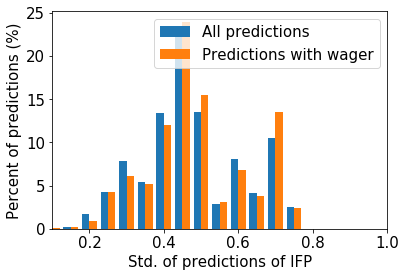

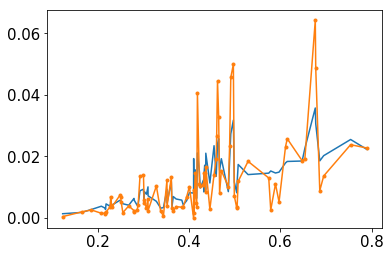

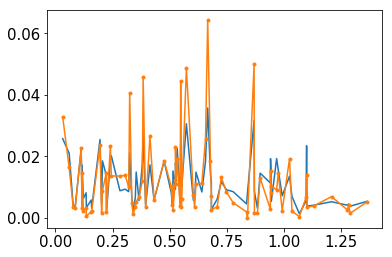

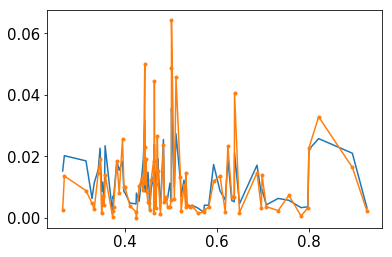

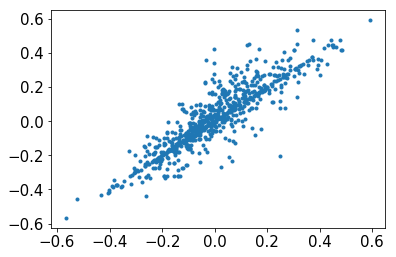

2094
728
368 216
0.505494505495 0.296703296703
222
2094
880
728
728
0
0


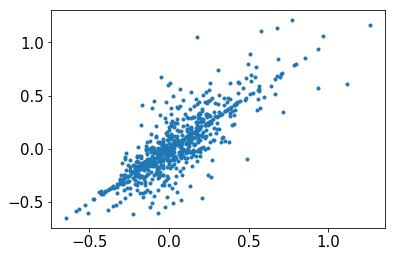

0.377747252747 0.424450549451


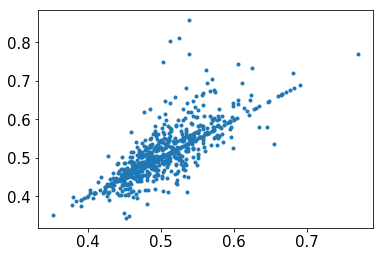

342 242


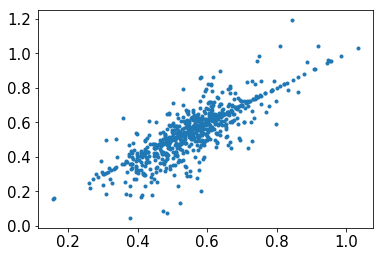

263 321


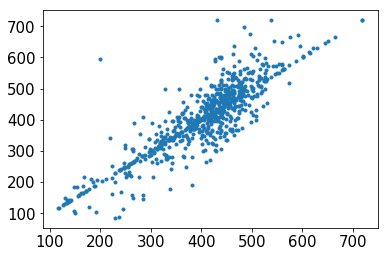

328 256
[ 0.2823  1.13    0.6035  1.2079  0.3946  0.3249  0.6662  0.7258  0.2406
  1.1003  0.548   0.5118  1.0965  0.3658  0.4316  1.024   1.2821  0.3345
  0.5455  0.8836  0.8692  0.1587  1.3631  1.2773  0.5251  0.6824  1.0669
  0.321   0.5136  0.3838  1.0349  0.0318  0.305   0.2227  0.38    0.0866
  0.5729  0.6089  0.1128  0.4136  0.1354  0.0601  0.2234  0.4756  0.6406
  0.941   0.6783  0.5522  0.1166  0.0776  0.7482  0.1952  0.615   0.8401
  0.6566  0.5251  0.9748  0.6823  0.5328  0.8956  0.2446  0.5068  0.3203
  0.9445  0.8361  0.1568  1.2895  0.1163  0.3394  0.7079  0.3495  0.7771
  0.202   0.1224  0.9921  0.9403  0.3534  0.2059  0.1344  0.5282  0.9428
  0.5512  0.8704  1.0988  0.9677  0.5142]
[188  88 122 112  88 450 761 251 402  82 511  92 117 120 124 289  96 134
 103  67 677  68 115  88 198  58  29 262 207 582 148 549 199 294 370  77
 652 123 474 367  71 448  38 394 180 410 300 215 365  90 195 543 317 172
 391 381 333 248 482 310 431 175 182 115  97 124  81 164  58 131 137 182
 

In [109]:
entr = (np.log(ifps_type)[:, None] - entropy_matrix(raw_preds[-1])) / np.log(ifps_type)[:, None]
preds = raw_preds[-1][:,:, 0]
wager = raw_wager[-1]
se = raw_se[-1]

#valid = ifps_type == 2
#entr = entr[valid]
#preds = preds[valid]
#wager = wager[valid]
#se = se[valid]

print(np.sum(ifps_type==2))
print(preds.shape)

var = np.std(preds, axis=1)

print(var.shape)

n, m = wager.shape

IFP_mean_se = np.nanmean(se, axis=1)
IFP_mean_entr = np.nanmean(entr, axis=1)
IFP_num_preds = np.nansum(preds>-0.1, axis=1)
IFP_num_wager = np.nansum(wager>0, axis=1)

Indi_mean_se_answered = np.zeros(m) * np.NAN
Indi_mean_se_wagered = np.zeros(m) * np.NAN
Indi_mean_entr_answered = np.zeros(m) * np.NAN
Indi_mean_entr_wagered = np.zeros(m) * np.NAN
Indi_mean_se_IFPs_answered = np.zeros(m) * np.NAN
Indi_mean_se_IFPs_wagered = np.zeros(m) * np.NAN
Indi_mean_entr_IFPs_answered = np.zeros(m) * np.NAN
Indi_mean_entr_IFPs_wagered = np.zeros(m) * np.NAN
Indi_mean_pop_answered = np.zeros(m) * np.NAN
Indi_mean_pop_wagered = np.zeros(m) * np.NAN
for i in range(m):
    curr_preds = preds[:, i]
    curr_wager = wager[:, i]
    if np.sum(curr_wager>0)<=1: continue
#    Indi_mean_se_answered[i] = np.mean(se[curr_preds>-0.1, i])
#    Indi_mean_se_wagered[i] = np.mean(se[curr_wager>0, i])
    Indi_mean_se_answered[i] = np.mean(se[curr_preds>-0.1, i]-IFP_mean_se[curr_preds>-0.1])
    Indi_mean_se_wagered[i] = np.mean(se[curr_wager>0, i]-IFP_mean_se[curr_wager>0])
    Indi_mean_entr_answered[i] = np.mean(entr[curr_preds>-0.1, i]-IFP_mean_entr[curr_preds>-0.1])
    Indi_mean_entr_wagered[i] = np.mean(entr[curr_wager>0, i]-IFP_mean_entr[curr_wager>0])
    Indi_mean_se_IFPs_answered[i] = np.mean(IFP_mean_se[curr_preds>-0.1])
    Indi_mean_se_IFPs_wagered[i] = np.mean(IFP_mean_se[curr_wager>0])
    Indi_mean_entr_IFPs_answered[i] = np.mean(IFP_mean_entr[curr_preds>-0.1])
    Indi_mean_entr_IFPs_wagered[i] = np.mean(IFP_mean_entr[curr_wager>0])
    Indi_mean_pop_answered[i] = np.mean(IFP_num_preds[curr_preds>-0.1])
    Indi_mean_pop_wagered[i] = np.mean(IFP_num_preds[curr_wager>0])
    
percentiles = 15
perc_num_preds = np.zeros(percentiles+1)
perc_num_wager = np.zeros(percentiles+1)
for i in range(percentiles+1):
    center = 0.75 / percentiles * i
    head = center - 0.75 / percentiles * 0.5
    tail = center + 0.75 / percentiles * 0.5
    valid = (var>=head) & (var<tail)
    perc_num_preds[i] = np.sum(IFP_num_preds[valid])/np.sum(IFP_num_preds)
    perc_num_wager[i] = np.sum(IFP_num_wager[valid])/np.sum(IFP_num_wager)
#    perc_mean_entr[i] = np.mean(vec_entr[valid])
    #perc_mean_wager[i] = np.mean(vec_wager[valid])
#    perc_mean_mse[i] = np.mean(vec_mse[valid])
#    perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
##x_axis = (np.arange(percentiles) + 0.5) / percentiles * 100
x_axis = np.arange(percentiles+1) / percentiles * 0.75
#print(x_axis)

print(perc_num_preds)
print(np.sum(perc_num_wager))
plt.figure(12)
plt.bar(x_axis-0.01, perc_num_preds*100, width=0.02, align='center', label="All predictions")
plt.bar(x_axis+0.01, perc_num_wager*100, width=0.02, align='center', label="Predictions with wager")
plt.ylabel("Percent of predictions (%)")
plt.xlabel("Std. of predictions of IFP")
plt.xlim([0.1, 1])
plt.legend()
plt.show()
plt.close('All')

    
plt.figure(10)
index = np.argsort(var)
plt.plot(var[index], IFP_num_preds[index]/np.sum(IFP_num_preds),'-')
plt.plot(var[index], IFP_num_wager[index]/np.sum(IFP_num_wager),'.-')
plt.show()
plt.close('All')

plt.figure(11)
index = np.argsort(IFP_mean_se)
plt.plot(IFP_mean_se[index], IFP_num_preds[index]/np.sum(IFP_num_preds),'-')
plt.plot(IFP_mean_se[index], IFP_num_wager[index]/np.sum(IFP_num_wager),'.-')
plt.show()
plt.close('All')

plt.figure(11)
index = np.argsort(IFP_mean_entr)
plt.plot(IFP_mean_entr[index], IFP_num_preds[index]/np.sum(IFP_num_preds),'-')
plt.plot(IFP_mean_entr[index], IFP_num_wager[index]/np.sum(IFP_num_wager),'.-')
plt.show()
plt.close('All')
    
plt.figure(0)
plt.plot(Indi_mean_entr_answered, Indi_mean_entr_wagered, '.')
plt.show()
plt.close('All')

diff = Indi_mean_entr_wagered - Indi_mean_entr_answered
print(len(diff))
diff = diff[~np.isnan(diff)]
print(len(diff))
print(np.sum(diff>0), np.sum(diff<0))
print(np.sum(diff>0)/len(diff), np.sum(diff<0)/len(diff))
print(np.sum((np.nansum(wager[:,:]>0, axis=0)==np.nansum(preds[:,:]>-0.1, axis=0))
             & (np.nansum(preds[:,:]>-0.1, axis=0)>0)
            ))
num_wager = np.nansum(wager>0.1, axis=0)
num_preds = np.nansum(preds>-0.1, axis=0)
print(np.sum(num_preds>0))
print(np.sum(num_wager>0))
print(np.sum(~np.isnan(Indi_mean_entr_answered)))
print(np.sum(~np.isnan(Indi_mean_entr_wagered)))
print(np.sum(np.isnan(IFP_mean_se)))
print(np.sum(np.isnan(IFP_mean_entr)))

plt.figure(2)
plt.plot(Indi_mean_se_answered, Indi_mean_se_wagered, '.')
plt.show()
plt.close('All')

diff = Indi_mean_se_wagered - Indi_mean_se_answered
diff = diff[~np.isnan(diff)]
print(np.sum(diff>0)/len(diff), np.sum(diff<0)/len(diff))

plt.figure(1)
plt.plot(Indi_mean_entr_IFPs_answered, Indi_mean_entr_IFPs_wagered, '.')
plt.show()
plt.close('All')

diff = Indi_mean_entr_IFPs_wagered - Indi_mean_entr_IFPs_answered
diff = diff[~np.isnan(diff)]
print(np.sum(diff>0), np.sum(diff<0))

plt.figure(3)
plt.plot(Indi_mean_se_IFPs_answered, Indi_mean_se_IFPs_wagered, '.')
plt.show()
plt.close('All')

diff = Indi_mean_se_IFPs_wagered - Indi_mean_se_IFPs_answered
diff = diff[~np.isnan(diff)]
print(np.sum(diff>0), np.sum(diff<0))
    
plt.figure(4)
plt.plot(Indi_mean_pop_answered, Indi_mean_pop_wagered, '.')
plt.show()
plt.close('All')

diff = Indi_mean_pop_wagered - Indi_mean_pop_answered
diff = diff[~np.isnan(diff)]
print(np.sum(diff>0), np.sum(diff<0))
    
print(IFP_mean_se)
print(IFP_num_preds)